Plot the amount of time (in hours) spent during the 19th of August inside each grid box of a 10*10 km² mesh. This amount of time gives a idea of the **legitimacy** of each area to provide information with flights.

    - Loading National and Regional park data
    - Computing time spent
    - Plotting

## Imports 

In [1]:
from base_Imports_and_Functions import *

Thermals_db = xr.open_dataset(savenet_path+'Thermals_data_base.nc')

## Regional and National natural french parks

The json files are retreived from https://catalogue.parcnational.fr/ and https://www.data.gouv.fr/fr/datasets/parcs-naturels-regionaux-pnr-france-metropolitaine/ for the french national and regional parks.

In [3]:
## Parc régionaux

path = savejson_path +'france_pnr_polygon.json'

PR = gpd.read_file(path)
PR = PR.set_crs(epsg=3857)
PR = PR.to_crs(epsg=4326)

names = ['Parc naturel régional du Massif des Bauges','Parc naturel régional des Monts d\'Ardèche','Parc naturel régional des Baronnies provençales','Parc naturel régional de Chartreuse','Parc naturel régional du Vercors',
         'Parc naturel régional du Queyras']

PR_filt = PR[PR['name'].isin(names)]

## Parc nationaux

path = savejson_path +'pnx-aoa.geojson'

PN = gpd.read_file(path)

## legitimacy

### Thermals legitimacy

In [ ]:
thermal_19 = Thermals_db.where(
    (Thermals_db['dayofflight'] == 19),
    drop = True)

img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

dlon = (img_extent[1] - img_extent[0])/50
dlat = (img_extent[3] - img_extent[2])/50
res = np.zeros((50,50))

for i in tqdm(range(len(thermal_19['rawtime']))):
    indx = int((thermal_19['longitude'].values[i]-img_extent[0])/dlon)
    indy = int((thermal_19['latitude'].values[i]-img_extent[2])/dlat)

    if 0<=indx <50 and 0<=indy <50 :
        res[indx,indy] += 1 

for i in range(50):
    for j in range(50):
        if res[i,j] == 0 :
            res[i,j] = np.nan

res2 = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        res2[i,j] = res[j,i]

### All flights legitimacy

In [ ]:
img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

dlon = (img_extent[1] - img_extent[0])/50
dlat = (img_extent[3] - img_extent[2])/50
res3 = np.zeros((50,50))

directory = saveflights_path
days = ['IGC_19-08-2023/']#,'IGC_20-08-2023/','IGC_21-08-2023/','IGC_22-08-2023/','IGC_23-08-2023/','IGC_24-08-2023/']
type = ['Parapente/','Planeur/']

for i in range(len(days)):
    for j in range(2):
        liste_file = [f for f in os.listdir(directory + days[i] + type[j]) if f.endswith('.igc')]
        for file in tqdm(liste_file) :
            all_lon,all_lat,all_alti,all_time = read_igc(directory + days[i] + type[j] + file)
            
            for k in range(len(all_lon)):
                indx = int((all_lon[k]-img_extent[0])/dlon)
                indy = int((all_lat[k]-img_extent[2])/dlat)
            
                if 0<=indx <50 and 0<=indy <50 :
                    res3[indx,indy] += 1 

for i in range(50):
    for j in range(50):
        if res3[i,j] == 0 :
            res3[i,j] = np.nan

res4 = np.zeros((50,50))
for i in range(50):
    for j in range(50):
        res4[i,j] = res3[j,i]

### Organised in a netcdf file

In [ ]:
a,b = res2.shape
lats = []
lons = []
val2 = []
val4 = []

img_extent = (4.7942, 8.1545, 43.3545, 46.6707)

dlon = (img_extent[1] - img_extent[0])/50
dlat = (img_extent[3] - img_extent[2])/50
    
for i in range(a):
    for j in range(b):
        lats.append(i*dlat+img_extent[2])
        lons.append(j*dlon+img_extent[0])
        val2.append(res2[i,j]/(60*60))
        val4.append(res4[i,j]/(60*60))

num_events = len(val2)
num_data_points = 4
Hours_all = xr.Dataset(
    {
        'lat': (['event'], np.array(lats).astype(np.float32)),
        'lon': (['event'], np.array(lons).astype(np.float32)),
        'val2': (['event'], np.array(val2).astype(np.float32)),
        'val4': (['event'], np.array(val4).astype(np.float32))
    },
    coords={
        'event': np.arange(num_events)
    },
)

Hours_all.to_netcdf(savenet_path+'hours_leg.nc')

### Plotting

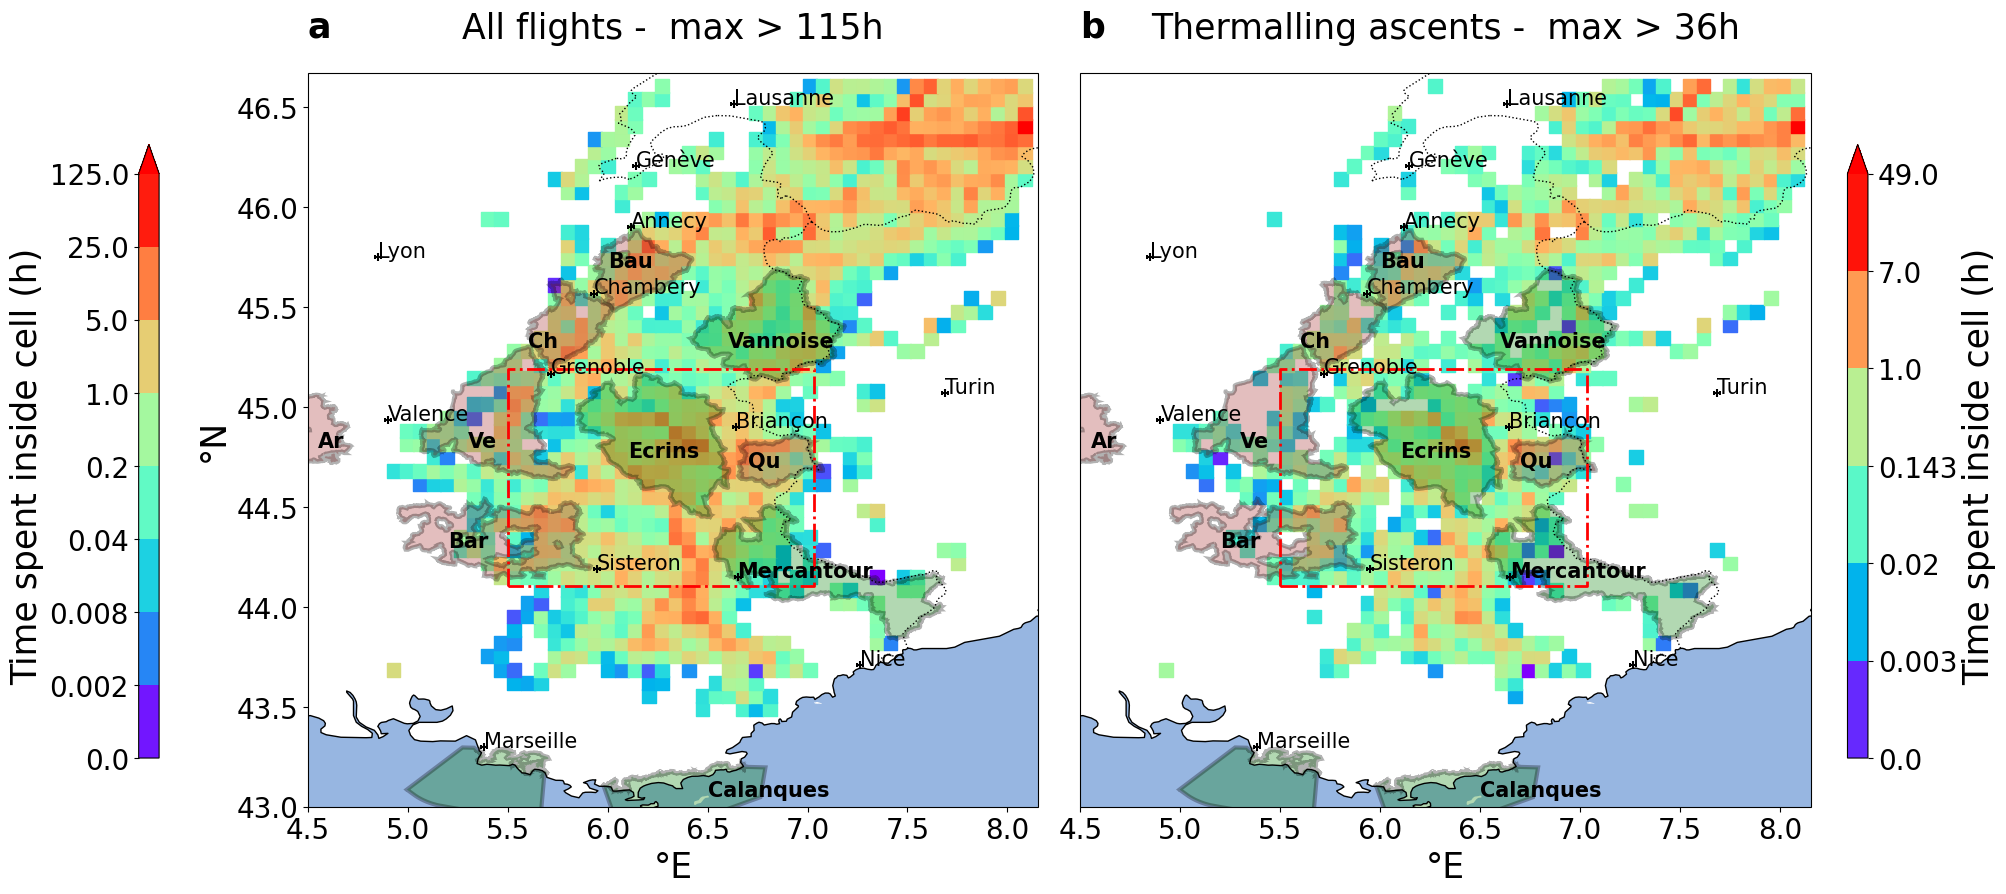

In [9]:
Hours_all = xr.open_dataset(savenet_path+'hours_leg.nc')

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize =  (20,11), subplot_kw={'projection': ccrs.PlateCarree()}, layout = 'constrained')

vars = ['val4','val2']
power = [5,7]
ranges = [4,3]
locs = ['left','right']
titles = ['All flights -  max > ' +str(int(np.nanmax(Hours_all['val4']))) + 'h','Thermalling ascents -  max > ' +str(int(np.nanmax(Hours_all['val2']))) + 'h']
names = ['Parc naturel régional du Massif des Bauges','Parc naturel régional des Monts d\'Ardèche','Parc naturel régional des Baronnies provençales',
         'Parc naturel régional de Chartreuse','Parc naturel régional du Vercors','Parc naturel régional du Queyras']

for i in range(2):
    ax = axs[i]

    ax.text(0, 1.05, string.ascii_lowercase[i], transform=ax.transAxes, 
        size=25, weight='bold')

    cax = ax.scatter(Hours_all['lon'],Hours_all['lat'],c = Hours_all[vars[i]],marker = 's', s = 100, cmap = 'rainbow', norm=colors.LogNorm())

    for k in range(len(PN['geometry'])):
        plotting.plot_polygon(PN['geometry'][k], ax=ax, add_points=False, color=None, facecolor='g', edgecolor='k', linewidth=3,alpha = 0.3)
    
    for k in range(len(PR['geometry'])):
        for l in names :
            if PR['name'][k] == l :
                plotting.plot_polygon(PR['geometry'][k], ax=ax, add_points=False, color=None, facecolor='brown', edgecolor='k', linewidth=3,alpha = 0.3)

    ticks = np.array([0] + [power[i]**j for j in range(-ranges[i],ranges[i])])
    
    cbar = plt.colorbar(cax,
                ax = ax,
                ticks = ticks,
                location = locs[i],
                extend='max',
                orientation='vertical',
                fraction = 0.028,
                aspect = 30,
                boundaries = ticks
                )
    
    cbar.ax.tick_params(labelsize=10) 
    cbar.set_label('Time spent inside cell (h)',fontsize = 25)

    cbar.ax.set_yticklabels([str(np.round(i*1000)/1000) for i in ticks],fontsize = 20)  # vertically oriented colorbar

    min_lon,max_lon,min_lat,max_lat = img_extent[0]-1, img_extent[1],img_extent[2]-1, img_extent[3]

    if i == 1 :
        yticks = []
        ylabels = []
    else :
        yticks = np.arange(42,47,1)
        ylabels = [str(l) for l in yticks]
        ax.set_ylabel("°N", fontsize = 25)
    
    xticks = np.arange(5,9,1)
    xlabels = [str(l) for l in xticks]
    ax.set_xticks(xticks,xlabels, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks,ylabels, crs=ccrs.PlateCarree())
    
    ax.set_xlabel("°E", fontsize = 25)
    ax.set_title(titles[i], fontsize = 25)

    ax.set_extent([4.5,max_lon,43,max_lat], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    lats_ville = [44.8997800,44.1875800,45.1666700,45.5666700,46.2043907,45.900002,43.29695,43.7101728,45.0704900,46.5160000,45.75,44.933331,44.15,44.75,45.30,43.05]
    lons_ville = [6.6420100,5.9462300,5.7166700,5.9333300,6.1431577,6.11667,5.38107,7.2619532,7.6868200,6.6328200,4.85,4.9,6.65,6.10,6.60,6.5]
    names_ville = ['Briançon','Sisteron','Grenoble','Chambery','Genève','Annecy','Marseille','Nice','Turin','Lausanne','Lyon','Valence','Mercantour',
                   'Ecrins','Vannoise','Calanques']
    lons_PR = [6.70,5.2,4.55,5.3,6,5.6]
    lats_PR = [44.70,44.3,44.8,44.8,45.7,45.3]
    names_PR = ['Qu','Bar','Ar','Ve','Bau','Ch']
    
    ax.scatter(lons_ville[:-3],lats_ville[:-3],marker = '+',color = 'k')
    
    for i, txt in enumerate(names_ville):
        if i <= len(names_ville)-5 :
            ax.annotate(txt, (lons_ville[i], lats_ville[i]),size = 15)
        else : 
            ax.annotate(txt, (lons_ville[i], lats_ville[i]),size = 15, weight = 'bold')
            
    for i,txt in enumerate(names_PR):
        ax.annotate(txt, (lons_PR[i], lats_PR[i]),size = 15, weight = 'bold')
    extent_son = (5.499792, 7.032229, 44.104446, 45.18888)
    xxs = (extent_son[0],extent_son[0],extent_son[1],extent_son[1],extent_son[0])
    yys = (extent_son[2],extent_son[3],extent_son[3],extent_son[2],extent_son[2])
    ax.plot(xxs,yys,linewidth = 2,color = 'r',linestyle ='dashdot')

plt.savefig(savefig_path+'legitimacy_f.png')